In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import TwoModels

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Создание новых признаков

In [3]:
path = 'E:/retailhero-uplift/data'

In [22]:
uplift = pd.read_csv(path + '/train.csv', encoding='utf-8')
uplift.head()

,client_id,first_issue_date,first_redeem_date,age,gender,treatment_flg,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0,1
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,1
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,1


In [19]:
uplift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 7 columns):
client_id            200039 non-null object
first_issue_date     200039 non-null object
first_redeem_date    182493 non-null object
age                  200039 non-null int64
gender               200039 non-null object
treatment_flg        200039 non-null int64
target               200039 non-null int64
dtypes: int64(3), object(4)
memory usage: 10.7+ MB


In [25]:
purchases = pd.read_csv(path + '/purchases.csv', encoding='utf-8')
purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [11]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
client_id                  object
transaction_id             object
transaction_datetime       object
regular_points_received    float64
express_points_received    float64
regular_points_spent       float64
express_points_spent       float64
purchase_sum               float64
store_id                   object
product_id                 object
product_quantity           float64
trn_sum_from_iss           float64
trn_sum_from_red           float64
dtypes: float64(8), object(5)
memory usage: 4.4+ GB


Извлечение признаков из временных меток:
 - месяц
 - день недели
 - час

Из файла с покупками сделаем такие признаки за всю историю и последние 30 дней: 
   - общее количество покупок(штуки и суммы)
   - количество накопленных баллов
   - количество потраченных баллов
   - количество уникальных магазинов, где были совершены покупки

Добавим описательные статистики:
 - среднее
 - стандартное отклонение
 - квартили
 - минимумы
 - максимумы

И добавим функциональные зависимости:
 - полиномы
 - логарифмы
 - экспоненты

## 0. Используемые классы и функции

Класс для выбора колонки.

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.column]]

Класс для преобразования возраста.

In [6]:
class AgeTransformator(BaseEstimator, TransformerMixin):
    
    def __init__(self, key, age_min, age_max):
        self.key = key
        self.age_min = age_min
        self.age_max = age_max
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, age_min  = 16, age_max = 80):
        X.loc[X[self.key] > self.age_max, self.key] = self.age_max
        X.loc[X[self.key] < self.age_min, self.key] = self.age_min
        return X

Класс для преобразования и извлечения фичей из дат.

In [37]:
class DateTransformator(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        B = [self.key+'_'+'int', self.key+'_'+'month', self.key+'_'+'weekday', self.key+'_'+'hour']
        self.columns = B
        return self
    
    def transform(self, X):
        Xp = X.values
        X[self.key+'_'+'month'] = X[self.key].dt.month
        X[self.key+'_'+'weekday'] = X[self.key].dt.weekday
        X[self.key+'_'+'hour'] = X[self.key].dt.hour
        X[self.key+'_'+'int'] = X[self.key].astype(np.int64)
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return И[self.columns]

Функция для создания фичей из purchase.

In [30]:
def purchase_features(last_cols, df):
    all_hist = df.groupby(['client_id','transaction_id'])[last_cols].last()
    last_month = df[df['transaction_datetime'] > '2019-02-18'].groupby(['client_id','transaction_id'])[last_cols].last()
    
    features =  pd.concat([all_hist.groupby('client_id')['purchase_sum'].count(),
                       last_month.groupby('client_id')['purchase_sum'].count(),
                       all_hist.groupby('client_id').sum(),
                       all_hist.groupby('client_id')[['store_id']].nunique(),
                       last_month.groupby('client_id').sum(),
                       last_month.groupby('client_id')[['store_id']].nunique(),
                      ],axis = 1)
    features.columns = ['total_trans_count','last_month_trans_count']+list(c+"_sum_all" for c in last_cols)+list(c+"_sum_last_month" for c in last_cols)
    
    return features

Классы для создания признаков: описательные статистики, функциональные зависимости.

In [62]:
class FeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self, key, tol: float = 1.01, p = 2):
        self.key = key
        self.tol = tol
        self.p = p
        self.columns = []
    
    def fit(self, X, y=None):
        self.columns = [self.key+'_'+'max', self.key+'_'+'min', self.key+'_'+'mean',
                       self.key+'_'+'std', self.key+'_'+'q1', self.key+'_'+'q2', 
                       self.key+'_'+'q3', self.key+'_'+'log', self.key+'_'+'exp',
                       self.key+'_'+'*2', self.key+'_'+'*3']
        return self
    
    def transform(self, X):
        X[self.key+'_'+'max'] = X[self.key].max()
        X[self.key+'_'+'min'] = X[self.key].min()
        X[self.key+'_'+'mean'] = X[self.key].mean()
        X[self.key+'_'+'std'] = X[self.key].std()
        X[self.key+'_'+'q1'] = X[self.key].quantile([0.25])
        X[self.key+'_'+'q2'] = X[self.key].quantile([0.5])
        X[self.key+'_'+'q3'] = X[self.key].quantile([0.75])
        X[self.key+'_'+'log'] = np.log(X[self.key] + tol) 
        X[self.key+'_'+'exp'] = np.exp(X[self.key] + tol)
        X[self.key+'_'+'*2'] = np.power(X[self.key], p)
        X[self.key+'_'+'*3'] = np.power(X[self.key], p+1)
        return X[self.columns]

Функция для создания парного признака пол-возраст.

In [78]:
def conjunction_features(data, columns=[]):
    data[columns[0] +'_'+ columns[1]] = list(zip(columns[0], columns[1]))
    return data[columns[0] +'_'+ columns[1]]

Функция для mean target кодирования.

In [86]:
def mean_target_encoding(train_df, y_train, valid_df, skf, cat_features):    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()  

    for col in cat_features:
        new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(cat_features + ['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_target'] = means.fillna(glob_mean)
        
    valid_df.drop(train_df.columns[train_df.dtypes == 'object'], axis=1, inplace=True)
    
    return new_train_df, valid_df

Класс для тюнинга XGBoost.

In [80]:
class XGBooostTuning:
    
    #оптимизация
    def optimize(params, cv_params, data):
        if 'max_depth' in params.keys():
            params['max_depth'] = int(params['max_depth'])

        cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
        name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
        score = cv_result[name][-1:].values[0]
    
        return {'loss': score, 'status': STATUS_OK}

    
    def tune(cv_params, space_freq, train_c, valid_c):
        trials = Trials()
        best_params = fmin(fn=partial(optimize, cv_params=cv_params, data=train_c),
                space=space_freq, trials=trials, algo=tpe.suggest, max_evals=15, timeout=3600)

        return best_params
    
    
    # Построение модели с ранней остановкой (early stopping)
    def early_stopping_xgb(best_params, train_params, train_c, valid_c):
        progress = dict()
        xgb_freq = xgb.train(params=best_params, dtrain=train_c, early_stopping_rounds=10,
                         evals=[(train_c, "train"), (valid_c, "valid")],
                         evals_result=progress, **train_params)
        preds=model.predict(valid_c)
        return preds
    
    
    #Визуализация Roc-Auc
    def roc_auc_plot(y_test, preds):
        sns.set(font_scale=1.5)
        sns.set_color_codes("muted")

        plt.figure(figsize=(10, 8))
        fpr, tpr, thresholds_ = roc_curve(y_test, preds, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
    
    #численная оценка roc-auc
    def grader(y_test, preds):
        score = roc_auc_score(y_test, preds)
        return score

Функция для двух независимых моделей.

In [83]:
def two_models(best, train_param, estimator, train_mean_target_part, y_train, treat_train, X_valid):
    tm = TwoModels(
        estimator_trmnt=estimator(params=best, **train_params), 
        estimator_ctrl=estimator(params=best, **train_params))

    tm = tm.fit(train_mean_target_part, y_train, treat_train)

    uplift_tm = tm.predict(X_valid)
    
    tm_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.3)
    
    return tm_score_30

## 1. Feature engineering. Часть 1

Начнём с создания фичей из purchase. Заджойним и будем работать с новым датасетом.

In [31]:
last_cols = ['regular_points_received', 'express_points_received','regular_points_spent', 'express_points_spent', 'purchase_sum','store_id',
            'product_quantity']

In [32]:
features = purchase_features(last_cols=last_cols,
                 df=purchases)

In [33]:
uplift = uplift.join(features, on='client_id')
uplift.to_csv(path + '/uplift_features.csv', index=False, encoding='utf-8')

In [4]:
uplift = pd.read_csv(path + '/uplift_features.csv', index_col='client_id', parse_dates=['first_issue_date', 'first_redeem_date'])
uplift.head()

,first_issue_date,first_redeem_date,age,gender,treatment_flg,target,total_trans_count,last_month_trans_count,regular_points_received_sum_all,express_points_received_sum_all,...,purchase_sum_sum_all,store_id_sum_all,product_quantity_sum_all,regular_points_received_sum_last_month,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,purchase_sum_sum_last_month,store_id_sum_last_month,product_quantity_sum_last_month
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0,1,4,2,25.7,0.0,...,2803.00,4.0,3,10.0,0.0,0.0,0.0,1222.00,2.0,1
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1,32,8,54.9,60.0,...,9805.00,32.0,5,13.7,0.0,0.0,0.0,2784.00,8.0,4
00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1,18,8,31.8,0.0,...,5883.00,17.0,2,13.9,0.0,0.0,0.0,2858.00,8.0,2
0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,1,15,7,78.9,0.0,...,6155.18,15.0,4,47.0,0.0,0.0,0.0,2211.37,6.0,2
00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,1,18,5,286.1,0.0,...,25819.61,27.0,4,58.4,0.0,-76.0,-10.0,6096.27,7.0,1


Для начала поработаем с новыми фичами из purchases, извлечём фичи из времени, обработаем возраст и создадим парный признак 
пол-возраст. После закодируем категориальные переменные.

In [9]:
dates = ['first_issue_date', 'first_redeem_date']
cat_features = uplift.columns[uplift.dtypes == 'object'].tolist()
num_features = uplift.columns[uplift.dtypes == 'int64'].tolist() + uplift.columns[uplift.dtypes == 'float64'].tolist()
num_features.remove('treatment_flg')
num_features.remove('target')

In [38]:
final_transformers = []

age = Pipeline([('selector', ColumnSelector(column='age')),
                ('age', AgeTransformator(key='age', age_min = 16, age_max = 80))
               ])
      


for date in dates:
    prepare_date = Pipeline([
        ('selector', ColumnSelector(column=date)),
        ('transformer', DateTransformator(key=date))
    ])
    
    final_transformers.append((date, prepare_date))
    
for feature in num_features:
    num_selector = Pipeline([
                ('selector', ColumnSelector(column=feature))
    ])
    
    final_transformers.append((feature, num_selector))
        
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

VV = feature_processing.fit_transform(uplift)
VV

ValueError: Shape of passed values is (200039, 1), indices imply (200039, 4)

In [27]:
index_train, index_valid = train_test_split(uplift.index, test_size=0.3, random_state=43)

X_train = uplift.loc[index_train, :].drop(['target', 'treatment_flg'], 1)
y_train = uplift.loc[index_train, 'target']
treat_train = uplift.loc[index_train, 'treatment_flg']

X_valid = uplift.loc[index_valid, :].drop(['target', 'treatment_flg'], 1)
y_valid = uplift.loc[index_valid, 'target']
treat_valid = uplift.loc[index_valid, 'treatment_flg']

In [ ]:
age.fit_transform(X_train)

Посмотрим на распределения вещественных признаков.

NameError: name 'X_test' is not defined

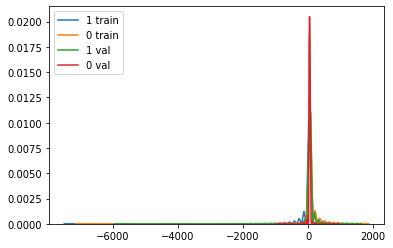

In [42]:
for i in X_train[num_features]:
        sns.kdeplot(X_train.loc[y_train == 1,i], label = '1 train')
        sns.kdeplot(X_train.loc[y_train == 0,i], label ='0 train')
        
        sns.kdeplot(X_valid.loc[y_valid == 1,i], label = '1 val')
        sns.kdeplot(X_valid.loc[y_valid == 0,i], label =  '0 val')
        
        sns.kdeplot(X_test.loc[y_test == 1,i], label = '1 test')
        sns.kdeplot(X_test.loc[y_test == 0,i], label =  '0 test')
        plt.title(i)
        plt.legend()
        plt.show()  

In [ ]:
age.fit_transform(X_train)


In [85]:
#train_c = xgb.DMatrix(train_mean_target_part, Y_train)
#valid_c = xgb.DMatrix(valid_mean_target, y_valid)

In [81]:
#параметры кроссвалидации
cv_params = {'num_boost_round': 600,
             'nfold': 12,
             'shuffle': True,
             'stratified': True,
             'maximize': False,
             'early_stopping_rounds': 20
              }
    
#пространство поиска
space_freq = {
              'objective': 'binary:logistic',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }
    
train_params = {
                'num_boost_round': 600,
                'maximize': False,
                'verbose_eval': False}